In [4]:
import tensorflow as tf

# load the model
model = tf.keras.models.load_model('unet_model')

In [5]:
# load the test data
import os

data_dir = 'data'
mask_dir = "external_contours_masks"
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')
test_masks_dir = os.path.join(mask_dir, 'test')
train_masks_dir = os.path.join(mask_dir, 'train')

# Create a folder with results and subfolders for cropped images, heatmaps and dijkstra
results_dir = 'external_contours_masks/results'
cropped_dir = os.path.join(results_dir, 'cropped')
heatmaps_dir = os.path.join(results_dir, 'heatmaps')
dijkstra_dir = os.path.join(results_dir, 'dijkstra')

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    os.mkdir(cropped_dir)
    os.mkdir(heatmaps_dir)
    os.mkdir(dijkstra_dir)

In [6]:
# run over the test data and predict the masks
# Find the contour of the mask
# Crop the image according to the contour

import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def crop_image(img, contour):
    # Resize the contour to the original image size from 128x128 to 4096x4096
    # Add erosion to the contour to make sure the mask will cover the whole tumor
    contour = 32 * contour
    # Create a mask with the contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    # Apply the mask to the image
    img = cv2.bitwise_and(img, mask)
    return img


def predict_mask(img):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

def get_mask(img):
    # Find the mask
    mask = predict_mask(img)
    # Find the contour of the mask
    contour = get_contour(mask)
    # Crop the image according to the contour
    img = crop_image(img, contour)
    return img

def get_masked_image(img):
    # Find the mask
    img = get_mask(img)
    img[img == 0] = 0
    return img

directories = [test_dir, train_dir]
for directory in directories:
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = get_masked_image(img)
        # Write the image to the results/cropped folder
        img_path = os.path.join(cropped_dir, img_name)
        cv2.imwrite(img_path, img)

1/1 [==============================] - 0s 43ms/step


In [ ]:
# Create heatmaps of the magnitude of the gradient
def get_heatmap(img, contour):
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # create a mask with the contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    _, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh, (13,13), 0)
    #edges = cv2.Canny(blur, 50, 150)
    # Run Sobel filter on the original image
    sobelx = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)
    # Find the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Normalize the image
    sobel_magnitude = sobel_magnitude/sobel_magnitude.max()*255
    # Convert to uint8
    sobel_magnitude = np.uint8(sobel_magnitude)

    window_size = 201 # Odd number only
    window_step = 10
    heat_map = np.zeros_like(img)
    # pad the images with zeros
    sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
    mask_metal_c = np.pad(mask, int((window_size-1)/2), mode='constant', constant_values=0)
    for y in range(0, sobel_c.shape[0], window_step):
        for x in range(0, sobel_c.shape[1], window_step):
            window = sobel_c[y:y+window_size, x:x+window_size]
            mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
            if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
                heat_map[y:y+window_step, x:x+window_step] = 0
            else:
                heat_map[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

    heat_map = cv2.equalizeHist(heat_map)
    heat_map = cv2.applyColorMap(heat_map, cv2.COLORMAP_JET)
    return heat_map

for img_name in os.listdir(cropped_dir):
    img_path = os.path.join(cropped_dir, img_name)
    img = cv2.imread(img_path)
    # Find the mask
    mask = predict_mask(img)
    # Find the contour of the mask
    contour = get_contour(mask)
    contour = contour * 32
    # Find the heatmap
    heatmap = get_heatmap(img, contour)
    # Write the image to the results/heatmaps folder
    img_path = os.path.join(heatmaps_dir, img_name)
    cv2.imwrite(img_path, heatmap)

In [10]:
def no_search_two_point(heat_map_sobel, contour):
    # Find start and end points of the shortest path
    center = [int((heat_map_sobel.shape[0]) / 2), int((heat_map_sobel.shape[1]) / 2)]
    metal_contour = 0.96 * (contour[:, 0, :] - center) + center
    # Convert to int
    metal_contour = metal_contour.astype(int)

    # Sample heat_map_sobel at largest_contour to find the metal edge points
    metal_edge_points = heat_map_sobel[metal_contour[:, 1], metal_contour[:, 0]]

    # Smooth the curve using circular convolution
    kernel_size = 300
    kernel = np.ones(kernel_size) / kernel_size
    padded_vector = np.pad(metal_edge_points, (kernel_size - 1, kernel_size - 1), mode='wrap')
    metal_edge_points_smooth = np.convolve(padded_vector, kernel, mode='valid')

    # Find the index of the minimum value in the smoothed curve
    min_index_1 = np.argmin(metal_edge_points_smooth)

    no_search_window = 0.2  # Fraction of the total length of the curve
    search_window_size = int(no_search_window * len(metal_edge_points_smooth))

    # Find second minimum value in the smoothed curve outside the search window
    start_index = max(0, min_index_1 - search_window_size // 2)
    end_index = min(len(metal_edge_points_smooth), min_index_1 + search_window_size // 2)

    # Limit the alteration to the smoothed curve within the defined search window
    metal_edge_points_smooth_2 = metal_edge_points_smooth.copy()
    metal_edge_points_smooth_2[start_index:end_index] = 255
    min_index_2 = np.argmin(metal_edge_points_smooth_2)

     # Ensure indices are within bounds
    min_index_1 = min(min_index_1, len(metal_contour) - 1)
    min_index_2 = min(min_index_2, len(metal_contour) - 1)
    return metal_contour[min_index_1], metal_contour[min_index_2]


In [11]:
import heapq

def dijkstra(image, start, end, path_factor=0.1):
  if(image[start[0], start[1]] == 0):
    print("start point is black")
    return []
  if(image[end[0], end[1]] == 0):
    print("end point is black")
    return []

  # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Create a graph where each node is a pixel in the image.
  graph = {}
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      graph[i, j] = []

  # Add edges to the graph for each pair of adjacent pixels.
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
          if di != 0 or dj != 0:
            ni = i + di
            nj = j + dj
            if 0 <= ni < image_array.shape[0] and 0 <= nj < image_array.shape[1]:
              graph[i, j].append((ni, nj))

  # Initialize the distance from the start point to all other points to infinity.
  distances = {}
  for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
      distances[i, j] = np.inf

  # Set the distance from the start point to itself to 0.
  distances[start[0], start[1]] = 0

  # Use Dijkstra's algorithm to find the shortest path from the start point to the end point.
  queue = [(0, start)]
  while queue:
    current_distance, current_node = heapq.heappop(queue)
    if current_node == end:
      break
    for neighbor in graph[current_node]:
      if(image[neighbor[0], neighbor[1]] == 0):
        continue
      new_distance = current_distance + image[neighbor[0], neighbor[1]]/255 + path_factor
      if distances[neighbor] > new_distance:
        distances[neighbor] = new_distance
        heapq.heappush(queue, (new_distance, neighbor))

  # Return the shortest path from the start point to the end point.
  path = []
  current_node = end
  while current_node != start:
    path.append(current_node)
    for neighbor in graph[current_node]:
      if distances[neighbor] < distances[current_node]:
        current_node = neighbor
        break

  path.append(start)
  path.reverse()
  return path

In [12]:
def resize_heat_map (heat_map, mask_metal, img_color):
    factor = 0.1 # Resize factor
    heat_map_resized = cv2.resize(heat_map, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
    mask_metal_resized = cv2.resize(mask_metal, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)
    img_color_resized = cv2.resize(img_color, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_NEAREST)

    # # Increase the pixels in heat_map_resized that are within the mask by 1
    # heat_map_resized[mask_metal_resized > 0] += 1
    # # Set all pixels in heat_map_resized that are bigger than 255 to 255
    # heat_map_resized[heat_map_resized > 255] = 255
    return heat_map_resized, mask_metal_resized, img_color_resized

1/1 [==============================] - 0s 48ms/step


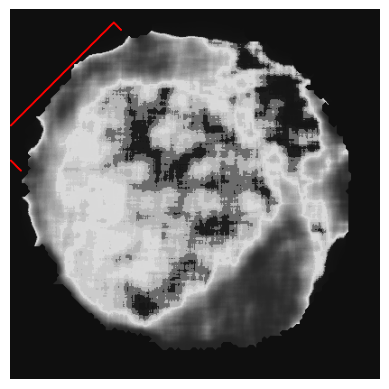

In [13]:
heat_map_sobel = cv2.imread('external_contours_masks/results/heatmaps/P1MF1_C.png')

img_path = os.path.join(cropped_dir, 'P1MF1_C.png')
img = cv2.imread(img_path)
# Find the mask
mask = predict_mask(img)
# Find the contour of the mask
contour = get_contour(mask)
contour = contour * 32
# Diminish the contour perimeter by 2 percent
contour = (0.85 * contour).astype(int)
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
heatmap_resized, mask_metal_resized, img_color_resized = resize_heat_map(heat_map_sobel, mask, img)

no_search_point1, no_search_point2 = no_search_two_point(cv2.cvtColor(heat_map_sobel, cv2.COLOR_BGR2GRAY), contour)

factor = 0.1
start = (int(no_search_point1[0]*factor), int(no_search_point1[1]*factor))
end = (int(no_search_point2[0]*factor), int(no_search_point2[1]*factor))

path = dijkstra(cv2.cvtColor(heatmap_resized,  cv2.COLOR_BGR2GRAY), start, end, path_factor=0.1)

img_sobol_shortest_path_color = heatmap_resized.copy()
img_sobel_shortest_path1 = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2GRAY)
img_sobel_shortest_path_gray1 = cv2.cvtColor(img_sobel_shortest_path1, cv2.COLOR_GRAY2RGB)
img_shortest_path1 = img.copy()

half_line_width = 1
for i in range(len(path) - 1):
    img_sobel_shortest_path_gray1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (255, 0,0)
    img_sobel_shortest_path1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = 255
    img_sobol_shortest_path_color[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (255, 0,0)

# Show the result
plt.axis('off')
plt.imshow(img_sobel_shortest_path_gray1, cmap='gray')


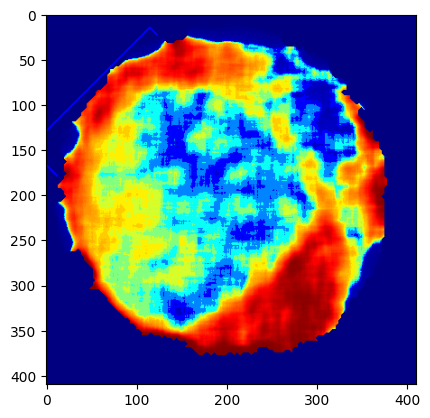

In [14]:
img_sobol_shortest_path_color = cv2.cvtColor(img_sobol_shortest_path_color, cv2.COLOR_BGR2RGB)
plt.imshow(img_sobol_shortest_path_color)

In [18]:
# Write the image to the results/dijkstra folder
for heatmap in os.listdir(heatmaps_dir):
    img_path = os.path.join(heatmaps_dir, heatmap)
    img = cv2.imread(img_path)
    # Find the mask
    mask = predict_mask(img)
    # Find the contour of the mask
    contour = get_contour(mask)
    contour = contour * 32
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    heatmap_resized, mask_metal_resized, img_color_resized = resize_heat_map(img, mask, img)
    no_search_point1, no_search_point2 = no_search_two_point(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), contour)
    factor = 0.1
    start = (int(no_search_point1[0]*factor), int(no_search_point1[0]*factor))
    end = (int(no_search_point2[1]*factor), int(no_search_point2[0]*factor))
    path = dijkstra(cv2.cvtColor(heatmap_resized,  cv2.COLOR_BGR2GRAY), start, end, path_factor=0.1)
    img_sobol_shortest_path_color = heatmap_resized.copy()
    img_sobel_shortest_path1 = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2GRAY)
    img_sobel_shortest_path_gray1 = cv2.cvtColor(img_sobel_shortest_path1, cv2.COLOR_GRAY2RGB)
    img_shortest_path1 = img.copy()
    half_line_width = 1
    for i in range(len(path) - 1):
        img_sobel_shortest_path_gray1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (0, 0,255)
        img_sobel_shortest_path1[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = 255
        img_sobol_shortest_path_color[(path[i][0]-half_line_width):(path[i][0]+half_line_width), (path[i][1]-half_line_width):(path[i][1]+half_line_width)] = (0, 0,255)
    # Write the image to the results/dijkstra folder
    img_path = os.path.join(dijkstra_dir, heatmap)
    img_sobol_shortest_path_color = img_sobol_shortest_path_color
    cv2.imwrite(img_path, img_sobol_shortest_path_color)


1/1 [==============================] - 0s 58ms/step


In [ ]:
# # create a docx file with the original image, the cropped, the heatmap and the dijkstra path
# from docx import Document
# from docx.shared import Inches
#
# document = Document()
# document.add_heading('Results', 0)
#
# directories = [test_dir, train_dir]
#
# for directory in directories:
#     for img_name in os.listdir(directory):
#         img_path = os.path.join(directory, img_name)
#         cropped_img = cv2.imread(os.path.join(cropped_dir, img_name))
#         heatmap_img = cv2.imread(os.path.join(heatmaps_dir, img_name))
#         dijkstra_img = cv2.imread(os.path.join(dijkstra_dir, img_name))
#         document.add_heading(img_name, level=1)
#         document.add_picture(img_path, width=Inches(3))
#         # add labels to the images
#         document.add_paragraph('Original image')
#         document.add_paragraph('Cropped image')
#         document.add_paragraph('Heatmap')
#         document.add_paragraph('Dijkstra path')
#         document.add_picture(os.path.join(cropped_dir, img_name), width=Inches(3))
#         document.add_picture(os.path.join(heatmaps_dir, img_name), width=Inches(3))
#         document.add_picture(os.path.join(dijkstra_dir, img_name), width=Inches(3))
#         document.add_page_break()
#
# document.save('results.docx')




In [19]:
directories = [test_dir, train_dir]

# Load and resize images outside the loop
images = []
files_names = []
for directory in directories:
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        cropped_img_path = os.path.join(cropped_dir, img_name)
        heatmap_img_path = os.path.join(heatmaps_dir, img_name)
        dijkstra_img_path = os.path.join(dijkstra_dir, img_name)

        # Load and resize images
        original_img = cv2.imread(img_path)
        cropped_img = cv2.imread(cropped_img_path)
        heatmap_img = cv2.imread(heatmap_img_path)
        dijkstra_img = cv2.imread(dijkstra_img_path)

        # Resize images if needed
        width = 512
        original_img = cv2.resize(original_img, (width, int(width * original_img.shape[0] / original_img.shape[1])))
        cropped_img = cv2.resize(cropped_img, (width, int(width * cropped_img.shape[0] / cropped_img.shape[1])))
        heatmap_img = cv2.resize(heatmap_img, (width, int(width * heatmap_img.shape[0] / heatmap_img.shape[1])))
        dijkstra_img = cv2.resize(dijkstra_img, (width, int(width * dijkstra_img.shape[0] / dijkstra_img.shape[1])))

        images.append((original_img, cropped_img, heatmap_img, dijkstra_img))
        files_names.append(img_name)

# Prepare resized images and save temporarily
image_paths = []
for idx, (original_img, cropped_img, heatmap_img, dijkstra_img) in enumerate(images):
    # Save resized images temporarily
    cv2.imwrite(f"temp_original_{idx}.jpg", original_img)
    cv2.imwrite(f"temp_cropped_{idx}.jpg", cropped_img)
    cv2.imwrite(f"temp_heatmap_{idx}.jpg", heatmap_img)
    cv2.imwrite(f"temp_dijkstra_{idx}.jpg", dijkstra_img)

    # Store paths for later use in the PDF
    image_paths.append((f"temp_original_{idx}.jpg", f"temp_cropped_{idx}.jpg", f"temp_heatmap_{idx}.jpg", f"temp_dijkstra_{idx}.jpg"))

In [20]:
from fpdf import FPDF
import os
import cv2

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.set_font("Arial", size=12)

pdf.add_page()

# Define table columns and header
col_width = 45
row_height = 60
pdf.set_fill_color(200)
pdf.set_font("Arial", 'B', 16)
pdf.set_fill_color(255)  # Reset fill color

# Positioning variables for the images
x_pos = pdf.get_x()
y_pos = pdf.get_y()
count = 0

for original_img_path, cropped_img_path, heatmap_img_path, dijkstra_img_path in image_paths:
    # Check if there is enough space for the images, otherwise add a new page
    if y_pos + row_height * 3 > pdf.h - 15:
        pdf.add_page()
        x_pos = pdf.get_x()
        y_pos = pdf.get_y()

    pdf.set_xy(x_pos, y_pos)
    pdf.set_fill_color(200)
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(col_width, row_height, files_names[count],  border=1, ln=False, align="C", fill=True)
    pdf.cell(col_width, row_height, "Cropped Image", border=1, ln=False, align="C", fill=True)
    pdf.cell(col_width, row_height, "Heatmap", border=1, ln=False, align="C", fill=True)
    pdf.cell(col_width, row_height, "Line", border=1, ln=True, align="C", fill=True)
    pdf.set_fill_color(255)  # Reset fill color

    pdf.image(original_img_path, x_pos, y_pos + row_height, col_width)
    pdf.image(cropped_img_path, x_pos + col_width, y_pos + row_height, col_width)
    pdf.image(heatmap_img_path, x_pos + col_width * 2, y_pos + row_height, col_width)
    # Add image for additional column (adjust positioning and size)
    pdf.image(dijkstra_img_path, x_pos + col_width * 3, y_pos + row_height, col_width)

    y_pos += row_height * 3  # Move to the next row
    count += 1

# Delete temporary images after creating the PDF
for idx in range(len(images)):
    os.remove(f"temp_original_{idx}.jpg")
    os.remove(f"temp_cropped_{idx}.jpg")
    os.remove(f"temp_heatmap_{idx}.jpg")
    os.remove(f"temp_dijkstra_{idx}.jpg")

pdf.output("results.pdf")

''